# Instalações necessárias

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Bibliotecas necessárias

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose

import tsfresh
from tsfresh import select_features

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# caminho do google drive para leitura de dados
path = '/content/drive/MyDrive/AGRO/data_new/'

# Análise da série resposta



In [ ]:
# dados de rendimento (produtividade)
rend = pd.read_csv(path+'rendimento.csv', sep = ';', encoding = "ISO-8859-1")
# dados de produção bruta
prod = pd.read_csv(path+'producao.csv', sep = ';', encoding = "ISO-8859-1")

In [ ]:
# guardando os nomes dos municípios
municipios = rend['name'].values
# guardando os códigos IBGE dos municípios
codigos = prod[prod['Localidade'].isin(municipios)]['codigo_ibge'].values

In [ ]:
# geo DataFram com latitude e longitude dos municípios
position = pd.read_csv(path+'latlong.csv', sep = ',')

# criando um "geo DataFrame" com as coordenadas
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(position['longitude'], position['latitude'])]
geo_df = gpd.GeoDataFrame(position, 
                          crs = crs, 
                          geometry = geometry)

In [ ]:
# mapa do paraná com limites de municípios
mapa_pr = gpd.read_file('/content/drive/MyDrive/AGRO/shapefiles/PR_Municipios_2021.shp')
# selecionando apenas os municípios da região oeste
oeste_pr = mapa_pr[mapa_pr['NM_MUN'].isin(municipios)] 
# adicionando a produção média ao geo DataFrame
oeste_pr['PROD_MEDIA'] = prod['MEDIA'].values/1000         
# adicionando o rendimento médio ao geo DataFrame
oeste_pr['REND_MEDIA'] = rend['MEDIA'].values

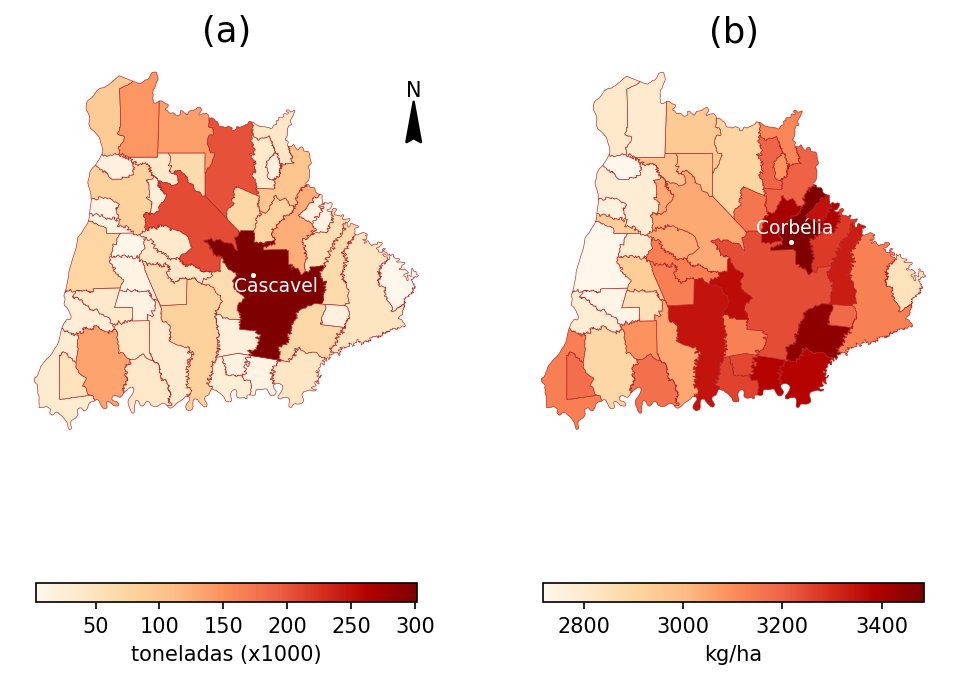

In [ ]:
# mapas de produção e produtividade média
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,8), dpi = 150)

oeste_pr.plot(ax = ax[0], column = 'PROD_MEDIA', legend = True,
              legend_kwds = {'label': 'toneladas (x1000)', 'orientation': 'horizontal','shrink':0.9},
              cmap = 'OrRd', edgecolor = 'firebrick', linewidth = 0.3)
geo_df[geo_df['nome']=='Cascavel'].plot(ax = ax[0], markersize = 2, color = 'white')
ax[0].annotate('Cascavel', xy = (-53.459,-24.9573), xytext=(11, -8), textcoords='offset points',
            ha='center' , fontsize = 9, color = 'white')
ax[0].axis("off")
ax[0].set_title('(a)', fontsize = 17)
ax[0].text(x=-52.65, y=-24.1, s='N', fontsize=10)
ax[0].arrow(-52.61, -24.3, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')

oeste_pr.plot(ax = ax[1], column = 'REND_MEDIA', legend = True,
              legend_kwds = {'label': 'kg/ha', 'orientation': 'horizontal','shrink':0.9},
              cmap = 'OrRd', edgecolor = 'firebrick', linewidth = 0.3)
geo_df[geo_df['nome']=='Corbélia'].plot(ax = ax[1], markersize = 2, color = 'white')
ax[1].annotate('Corbélia', xy = (-53.3006,-24.7971), xytext=(2, 4), textcoords='offset points',
            ha='center' , fontsize = 9, color = 'white')
ax[1].axis("off")
ax[1].set_title('(b)', fontsize = 17)
plt.show()
fig.savefig('prodrend.png')

In [ ]:
# Municípios top 10 em produtividade/rendimento
top10 = rend.sort_values(['MEDIA'],ascending = False).head(10)['name'].values

# criando um DF auxiliar
s_rend = pd.DataFrame(index = rend.columns[4:], columns = top10)
for i in top10:
  s_rend[i] = rend[rend['name']==i].drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).iloc[0].values

# adicionando a média de todos os 50 municípios
s_rend['Média']= rend.drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).mean(axis = 0)

In [ ]:
# criando uma paleta de cores
import itertools
palette = itertools.cycle(sns.color_palette('magma', 10))

# gráfico dos municípios top 10 em rendimento
fig, ax = plt.subplots(figsize = (8,4), dpi = 150)

for i in top10:
  c = next(palette)
  sns.lineplot(ax = ax, x = np.arange(2004,2022), y = s_rend[i], color = c)

sns.lineplot(ax = ax, x=np.arange(2004,2022), y = s_rend['Média'], linestyle = '--', color = 'red')
sns.regplot(x=np.arange(2004,2022), y=s_rend['Média'].values, ci=None, scatter = False, line_kws={'color': 'green', 'linestyle': 'dotted'})
ax.set_xlabel('Ano', fontsize = 10)
ax.set_ylabel('Produtividade (kg/ha)', fontsize = 10)
ax.legend(s_rend.columns, bbox_to_anchor = (1, -0.2), fontsize = 9, ncol = 4)
plt.xticks(np.arange(2004, 2022, 1.0))
plt.xticks(rotation=45)
plt.show()
#fig.savefig('top10.png',bbox_inches='tight')

# Remoção da tendência das séries de produtividade

In [ ]:
# função que retorna a produtividade histórica dado o nome do município e a base de dados
def rend_city(base, nome):
  return base[base['name'] == nome].drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).iloc[0].values

# função para remover a tendência da produtividade dado o nome do municipio e a base de dados
def remove_tend(base, nome):
  ys = rend_city(base, nome)
  ys = ys.reshape(len(ys), 1)
  xs = np.arange(2004,2022)
  xs = xs.reshape(len(xs), 1)
  lrc = LinearRegression()
  model = lrc.fit(xs, ys)
  pred = model.predict(xs)
  return ys - (pred.reshape(len(pred),1) - pred[0])

In [ ]:
idx = pd.date_range(start = '2004', end = '2022', freq='Y')
teste = pd.DataFrame({'Produtividade': rend_city(rend ,'Cascavel')}, index = idx)

seasonal_decompose(teste, model='additive').plot();

In [ ]:
# testando a função remove_tend
y_new = remove_tend(rend, 'Cascavel')

plt.plot(np.arange(2004,2022), y_new);

In [ ]:
# criando uma nova base de produtividade livre de tendência
rend_new = rend.copy()

for i in range(50):
  rend_new.loc[i, rend_new.columns[4:]] = remove_tend(rend, municipios[i]).reshape(-1)

# update da produtividade média
medias = []
for i in range(50):
  medias.append(rend_new.loc[i, rend_new.columns[4:]].mean())

rend_new['MEDIA'] = medias

In [ ]:
# checando a integridade dos dados
rend_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nivel        50 non-null     object 
 1   codigo_ibge  50 non-null     int64  
 2   name         50 non-null     object 
 3   MEDIA        50 non-null     float64
 4   2004         50 non-null     int64  
 5   2005         50 non-null     float64
 6   2006         50 non-null     float64
 7   2007         50 non-null     float64
 8   2008         50 non-null     float64
 9   2009         50 non-null     float64
 10  2010         50 non-null     float64
 11  2011         50 non-null     float64
 12  2012         50 non-null     float64
 13  2013         50 non-null     float64
 14  2014         50 non-null     float64
 15  2015         50 non-null     float64
 16  2016         50 non-null     float64
 17  2017         50 non-null     float64
 18  2018         50 non-null     float64
 19  2019      

In [ ]:
# verificando
# criando um DF auxiliar
s_rend2 = pd.DataFrame(index = rend.columns[4:], columns = top10)
for i in top10:
  s_rend2[i] = rend_new[rend_new['name']==i].drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).iloc[0].values

# adicionando a média de todos os 50 municípios
s_rend2['Média']= rend_new.drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).mean(axis = 0)

# criando uma paleta de cores
palette = itertools.cycle(sns.color_palette('magma', 10))

# gráfico dos municípios top 10 em rendimento
fig, ax = plt.subplots(figsize = (8,4), dpi = 150)

for i in top10:
  c = next(palette)
  sns.lineplot(ax = ax, x = np.arange(2004,2022), y = s_rend2[i], color = c)

sns.lineplot(ax = ax, x=np.arange(2004,2022), y = s_rend2['Média'], linestyle = '--', color = 'red')
sns.regplot(x=np.arange(2004,2022), y=s_rend2['Média'].values, ci=None, scatter = False, line_kws={'color': 'green', 'linestyle': 'dotted'})
ax.set_xlabel('Ano', fontsize = 10)
ax.set_ylabel('Produtividade (kg/ha)', fontsize = 10)
#ax.legend(s_rend.columns, bbox_to_anchor = (1, -0.2), fontsize = 9, ncol = 4)
plt.xticks(np.arange(2004, 2022, 1.0))
plt.xticks(rotation=45)
plt.show()
# fig.savefig('top10_tend.png',bbox_inches='tight')

# Análise das séries preditoras

In [ ]:
# Mapas de clima
clima = pd.read_csv(path+'agroclima.csv')

# Selecionando apenas os municípios do estudo
clima = clima[clima['codigo_ibge'].isin(codigos)]

In [ ]:
# adicionando a temperatura mínima e máxima média por município no mapa do oeste do Paraná
oeste_pr['TMIN_MED'] = clima.groupby('codigo_ibge').mean()['T2M_MIN'].values
oeste_pr['TMAX_MED'] = clima.groupby('codigo_ibge').mean()['T2M_MAX'].values
# adicionando a precipitação acumulada por município
oeste_pr['PREC_ACC'] = clima.groupby('codigo_ibge').sum()['PRECTOTCORR'].values

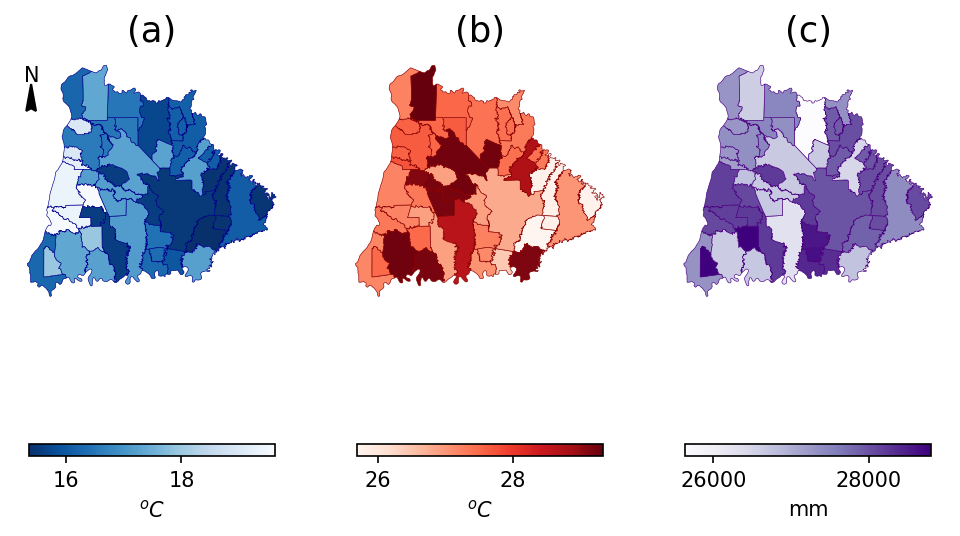

In [ ]:
# gráficos
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (8,8), dpi = 150)

oeste_pr.plot(ax = ax[0], column = 'TMIN_MED', legend = True,
              legend_kwds = {'label': '$^o C$','shrink':0.9, 'orientation': 'horizontal'},
              cmap = 'Blues_r', edgecolor = 'darkblue', linewidth = 0.3)
ax[0].axis("off")
ax[0].set_title('(a)', fontsize = 17)
ax[0].text(x=-54.65, y=-24.1, s='N', fontsize=10)
ax[0].arrow(-54.59, -24.3, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')

oeste_pr.plot(ax = ax[1], column = 'TMAX_MED', legend = True,
              legend_kwds = {'label': '$^o C$','shrink':0.9, 'orientation': 'horizontal'},
              cmap = 'Reds', edgecolor = 'darkred', linewidth = 0.3)
ax[1].axis("off")
ax[1].set_title('(b)', fontsize = 17)

oeste_pr.plot(ax = ax[2], column = 'PREC_ACC', legend = True,
              legend_kwds = {'label': 'mm','shrink':0.9, 'orientation': 'horizontal'},
              cmap = 'Purples', edgecolor = 'indigo', linewidth = 0.3)
ax[2].axis("off")
ax[2].set_title('(c)', fontsize = 17)

plt.show()
#fig.savefig('clima.png')

In [ ]:
# convertendo os índices para o formato datetime
clima = clima.reset_index(drop = True)
clima.index = pd.to_datetime(clima['data'].astype(str), format='%Y%m%d')

# criando uma coluna com o ano do estudo
clima['data'] = clima.index
clima['ano'] = clima['data'].dt.year

# reorganizando colunas
clima = clima.iloc[:, [0,38]+np.arange(1,38).tolist()]

# dropando a coluna redundante 'data'
clima = clima.drop('data', axis = 1)

clima.head()

ano  codigo_ibge  latitude  longitude  T2M_RANGE     TS  T2MDEW  \
data                                                                           
2003-01-01  2003      4101051  -24.6449   -53.1332       7.99  26.27   23.23   
2003-01-02  2003      4101051  -24.6449   -53.1332       6.47  25.70   23.36   
2003-01-03  2003      4101051  -24.6449   -53.1332       6.27  24.75   22.78   
2003-01-04  2003      4101051  -24.6449   -53.1332       6.38  24.50   22.21   
2003-01-05  2003      4101051  -24.6449   -53.1332       8.43  25.62   22.50   

            T2MWET  T2M_MAX  T2M_MIN  ...  GWETROOT  GWETPROF  \
data                                  ...                       
2003-01-01   24.83    30.21    22.21  ...      0.75      0.77   
2003-01-02   24.59    29.33    22.86  ...      0.75      0.77   
2003-01-03   23.78    28.03    21.76  ...      0.76      0.77   
2003-01-04   23.29    27.82    21.44  ...      0.79      0.79   
2003-01-05   23.95    29.68    21.24  ...      0.80      0.80   

            ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  TOA_SW_DWN  \
data                                                           
2003-01-01              27.77              31.76       42.93   
2003-01-02              24.21              31.01       42.91   
2003-01-03              19.60              30.05       42.89   
2003-01-04              17.09              29.50       42.86   
2003-01-05              24.76              30.89       42.83   

            ALLSKY_SFC_PAR_TOT  CLRSKY_SFC_PAR_TOT  ALLSKY_SFC_UVA  \
data                                                                 
2003-01-01              151.07              169.98           20.33   
2003-01-02              132.70              167.05           18.12   
2003-01-03              110.20              163.97           15.33   
2003-01-04               96.17              158.87           13.24   
2003-01-05              134.60              165.02           18.11   

            ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  
data                                             
2003-01-01            0.63                 3.31  
2003-01-02            0.56                 2.95  
2003-01-03            0.48                 2.49  
2003-01-04            0.43                 2.23  
2003-01-05            0.56                 2.94  

[5 rows x 38 columns]

In [ ]:
# Adicionando colunas para receber os dados de NDVI e Evapotranspiração
clima['NDVI'] = np.zeros(clima.shape[0])
clima['EVT'] = np.zeros(clima.shape[0])

# adicionando os valores de NDVI e Evapotranspiração
for i in codigos:
  ne = pd.read_csv(path+'NDVI_EVT/'+str(i)+'.csv', decimal = ',', sep = ';', skiprows = 1, header = None)
  clima.loc[clima['codigo_ibge'] == i, 'NDVI'] = ne[ne.columns[1]].values
  clima.loc[clima['codigo_ibge'] == i, 'EVT'] = ne[ne.columns[2]].values

# substituindo NDVI menor que 0 por zero (ocorre em municípios com rios próximos)
clima.loc[clima['NDVI']<0, 'NDVI'] = 0

In [ ]:
# checando a integridade dos dados
clima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328750 entries, 2003-01-01 to 2020-12-31
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ano                  328750 non-null  int64  
 1   codigo_ibge          328750 non-null  int64  
 2   latitude             328750 non-null  float64
 3   longitude            328750 non-null  float64
 4   T2M_RANGE            328750 non-null  float64
 5   TS                   328750 non-null  float64
 6   T2MDEW               328750 non-null  float64
 7   T2MWET               328750 non-null  float64
 8   T2M_MAX              328750 non-null  float64
 9   T2M_MIN              328750 non-null  float64
 10  T2M                  328750 non-null  float64
 11  QV2M                 328750 non-null  float64
 12  RH2M                 328750 non-null  float64
 13  PRECTOTCORR          328750 non-null  float64
 14  PS                   328750 non-null  float64
 15  W

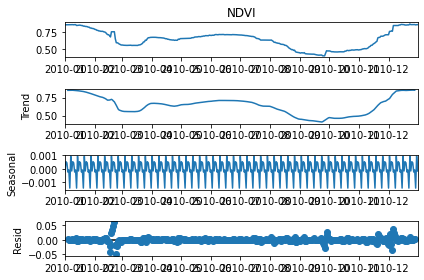

In [ ]:
seasonal_decompose(clima.loc[(clima['ano'] == 2010) & (clima['codigo_ibge'] == codigos[0]), 'NDVI'].asfreq('D'), model='additive').plot();

In [ ]:
seasonal_decompose(clima.loc[(clima['ano'] == 2015) & (clima['codigo_ibge'] == codigos[0]), 'EVT'].asfreq('D'), model='additive').plot();

In [ ]:
# função para filtrar atributos de uma cidade em um determinado ano (ou todos)
def filtrar_cidade(cod, ano):
  aux = clima.loc[clima['codigo_ibge'] == cod]
  if ano == 0:
    return aux
  else:
    return aux[aux['ano'] == ano][aux.columns[4:]]

# Filtrando para os meses de interesse (01-set a 31-dez)

In [ ]:
# função para filtrar séries das cidades no período de interesse
def filtrar_clima(cod):
  cidade = filtrar_cidade(cod, 0).loc[str(2003)+'-09-01' : str(2003)+'-12-31'].drop('ano', axis = 1)
  cidade.insert(0,'safra',0)
  cidade['safra'] = np.repeat(2004, cidade.shape[0])

  for i in np.arange(2004,2021):
    ano = i
    aux = filtrar_cidade(cod, 0).loc[str(i)+'-09-01' : str(i)+'-12-31'].drop('ano', axis = 1)
    aux.insert(0,'safra',0)
    aux['safra'] = np.repeat(i+1, aux.shape[0])
    cidade = pd.concat((cidade, aux), axis = 0)
  return cidade

In [ ]:
# função para gerar um geo DataFrame com as médias das variáveis entre Setembro e Dezembro
def geo_evolve(variavel):
  df = pd.DataFrame(np.zeros((oeste_pr.shape[0],4)), columns = [variavel+'_SET', variavel+'_OUT', variavel+'_NOV', variavel+'_DEZ'])
  colunas = df.columns.values
  for i in range(50):
    aux = filtrar_clima(codigos[i])
    mn = []
    for j in range(9,13):
      mn.append(aux.loc[aux.index.month == j].groupby('safra').mean()[variavel].mean())
    df.iloc[i] = mn

  oeste2 = oeste_pr.copy()
  oeste2 = oeste2.reset_index()
  oeste2[colunas] = df[colunas]
  return oeste2

# Evolução do NDVI (médias dos meses de setembro a dezembro)

In [ ]:
# obtendo os resumos
oeste2 = geo_evolve('NDVI')

# gráfico espacial
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols = 2, sharey = True, figsize = (8,8), dpi = 150)

g1 = oeste2.plot(ax = ax1, column = 'NDVI_SET', legend = True, scheme = 'user_defined',
                 classification_kwds = dict(bins=[0.25,0.50,0.75,1]),
                 legend_kwds = {'loc': 'upper right','fontsize': 12, 'title': 'NDVI'},
                 cmap = 'Greens', edgecolor = 'darkgreen', linewidth = 0.3)

g2 = oeste2.plot(ax = ax2, column = 'NDVI_OUT', legend = False, scheme = 'user_defined',
                 classification_kwds = dict(bins=[0.25,0.50,0.75,1]),
                 cmap = 'Greens', edgecolor = 'darkgreen', linewidth = 0.3)

g3 = oeste2.plot(ax = ax3, column = 'NDVI_NOV', legend = False, scheme = 'user_defined',
                 classification_kwds = dict(bins=[0.25,0.50,0.75,1]),
                 cmap = 'Greens', edgecolor = 'darkgreen', linewidth = 0.3)

g4 = oeste2.plot(ax = ax4, column = 'NDVI_DEZ', legend = False, scheme = 'user_defined',
                 classification_kwds = dict(bins=[0.25,0.50,0.75,1]),
                 cmap = 'Greens', edgecolor = 'darkgreen', linewidth = 0.3)

ax1.axis("off")
ax1.set_title('Setembro', fontsize = 17)
ax1.text(x=-54.5, y=-24.1, s='N', fontsize=10)
ax1.arrow(-54.465, -24.3, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')

ax2.axis("off")
ax2.set_title('Outubro', fontsize = 17)

ax3.axis("off")
ax3.set_title('Novembro', fontsize = 17)

ax4.axis("off")
ax4.set_title('Dezembro', fontsize = 17)

fig = plt.gcf()
plt.tight_layout()
plt.show()
#fig.savefig('ndvi1.png')

# Evolução das demais variáveis (médias dos meses de setembro a dezembro)

In [ ]:
# função para gerar os gráficos
def graph_evolve(variavel, colormap, cedge, legend):
  oeste2 = geo_evolve(variavel)
  bs = np.round(np.quantile(oeste2[oeste2.columns[-4:]], [0.25,0.5,0.75,1]),2)

  fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols = 2, sharey = True, figsize = (8,8), dpi = 150)

  g1 = oeste2.plot(ax = ax1, column = variavel+'_SET', legend = True, scheme = 'user_defined',
                   classification_kwds = dict(bins=bs),
                   legend_kwds = {'loc': 'upper right','fontsize': 12, 'title': legend},
                   cmap = str(colormap), edgecolor = str(cedge), linewidth = 0.3)

  g2 = oeste2.plot(ax = ax2, column = variavel+'_OUT', legend = False, scheme = 'user_defined',
                   classification_kwds = dict(bins=bs),
                   cmap = str(colormap), edgecolor = str(cedge), linewidth = 0.3)

  g3 = oeste2.plot(ax = ax3, column = variavel+'_NOV', legend = False, scheme = 'user_defined',
                   classification_kwds = dict(bins=bs),
                   cmap = str(colormap), edgecolor = str(cedge), linewidth = 0.3)

  g4 = oeste2.plot(ax = ax4, column = variavel+'_DEZ', legend = False, scheme = 'user_defined',
                   classification_kwds = dict(bins=bs),
                   cmap = str(colormap), edgecolor = str(cedge), linewidth = 0.3)

  ax1.axis("off")
  ax1.set_title('Setembro', fontsize = 17)
  ax1.text(x=-54.5, y=-24.1, s='N', fontsize=10)
  ax1.arrow(-54.465, -24.3, 0, 0.18, length_includes_head=True,
            head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')

  ax2.axis("off")
  ax2.set_title('Outubro', fontsize = 17)

  ax3.axis("off")
  ax3.set_title('Novembro', fontsize = 17)

  ax4.axis("off")
  ax4.set_title('Dezembro', fontsize = 17)

  fig = plt.gcf()
  plt.tight_layout()
  return fig

In [ ]:
fig = graph_evolve('EVT', 'Purples', 'darkblue', 'Evapotranspitação Potencial (mm)')
# fig.savefig('teste.png')

In [ ]:
fig = graph_evolve('PRECTOTCORR', 'Blues', 'darkblue', 'Precipitação (mm)')
# fig.savefig('teste.png')

## Filtrando para os meses de interesse (01-set a 31-jan)
### Resolvi eliminar o mês de janeiro, pois perderia as séries agroclimáticas de 2020

In [ ]:
# # função para filtrar séries das cidades no período de interesse

# def filtrar_clima(cod):
#   cidade = filtrar_cidade(cod, 0).loc[str(2003)+'-09-01' : str(2004)+'-01-31'].drop('ano', axis = 1)
#   cidade.insert(0,'safra',0)
#   cidade['safra'] = np.repeat(2004, cidade.shape[0])

#   for i in np.arange(2004,2020):
#     ano = i
#     aux = filtrar_cidade(cod, 0).loc[str(i)+'-09-01' : str(i+1)+'-01-31'].drop('ano', axis = 1)
#     aux.insert(0,'safra',0)
#     aux['safra'] = np.repeat(i+1, aux.shape[0])
#     cidade = pd.concat((cidade, aux), axis = 0)
#   return cidade

# Analisando as séries de:
- Corbélia (1ª posição em produtividade - 1/50);
- Ibema (17ª posição - 17/50);
- Nova Santa Rosa (33ª posição - 33/50);
- Mercedes (úlitima posição - 50/50).

In [ ]:
corb = filtrar_clima(codigos[10])
ibem = filtrar_clima(codigos[18])
nova = filtrar_clima(codigos[31])
merc = filtrar_clima(codigos[28])

# O que fazer com as séries de NDVI? Diferenciar?

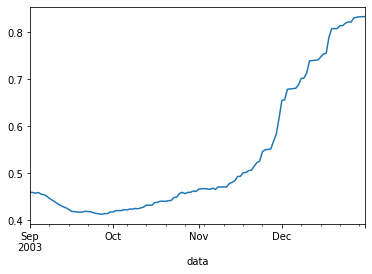

In [ ]:
corb.loc[corb['safra'] == 2004, 'NDVI'].plot();

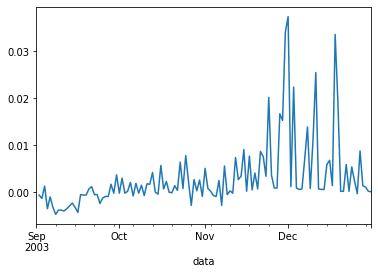

In [ ]:
corb.loc[corb['safra'] == 2004, 'NDVI'].diff().plot();

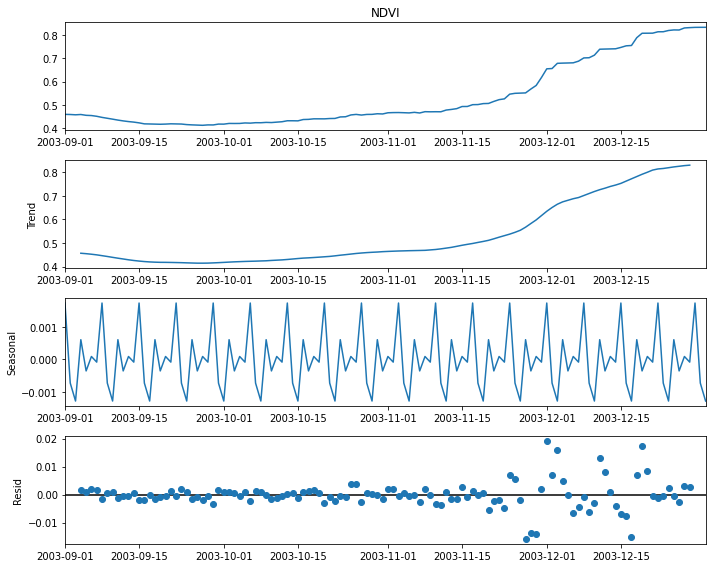

In [ ]:
fig = seasonal_decompose(corb.loc[(corb['safra'] == 2004), 'NDVI'].asfreq('D'), model='additive').plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

# O que fazer com as séries de EVT? Remover tendência?

In [ ]:
corb.loc[corb['safra'] == 2005, 'EVT'].plot();

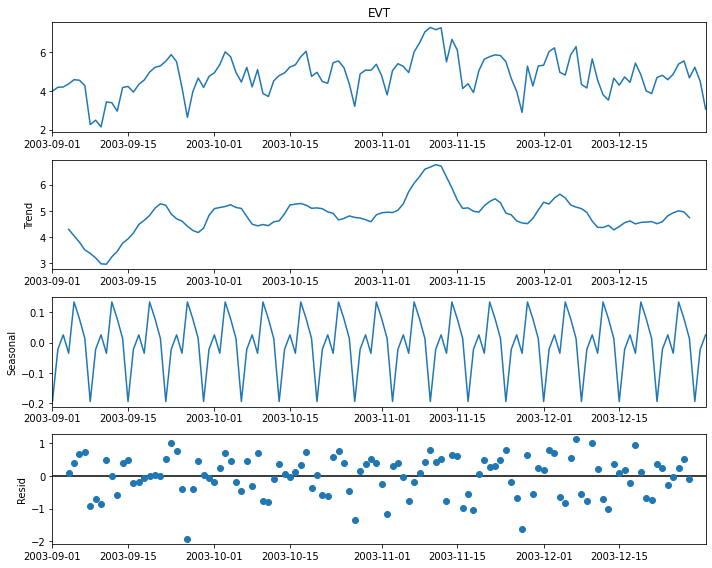

In [ ]:
fig = seasonal_decompose(corb.loc[(corb['safra'] == 2004), 'EVT'].asfreq('D'), model='additive').plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

# Correlações entre séries agroclimáticas (pré-seleção de covariáveis)

In [ ]:
# colunas de cada classe de variáveis
temps = corb.columns[4:11]
umids = corb.columns[11:14]
winds = corb.columns[14:27]
solos = corb.columns[27:30]
eners = corb.columns[30:38]

In [ ]:
# estudo de correlação entre atributos que permanecera na base
atrib = ['T2M_RANGE', 'T2M_MIN', 'T2M_MAX','QV2M', 'RH2M', 'PRECTOTCORR',
         'WS2M_RANGE','WS10M_RANGE','WS50M_RANGE','GWETTOP',
         'CLRSKY_SFC_PAR_TOT','ALLSKY_SFC_UVB','ALLSKY_SFC_UV_INDEX',
         'NDVI', 'EVT']

In [ ]:
# Mapas de calor para temperaturas

# temps - figsize (8,8)
# umids - figsize (4,4)
# winds - figsize (12,12)
# solos - figsize (4,4)
# eners - figsize(8,8)

feats = atrib
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols = 2, sharey = True, figsize = (12,12), dpi = 150)

g1 = sns.heatmap(corb[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax1, annot_kws={"size":9}, fmt=".2f")
g2 = sns.heatmap(ibem[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax2, annot_kws={"size":9}, fmt=".2f")
g3 = sns.heatmap(nova[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax3, annot_kws={"size":9}, fmt=".2f")
g4 = sns.heatmap(merc[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax4, annot_kws={"size":9}, fmt=".2f")

g1.set(xticklabels=[], title = '(a)')
g1.tick_params(left = False, bottom=False)
g2.set(xticklabels=[], title = '(b)')
g2.tick_params(left = False, bottom=False)
g3.set(title = '(c)')
g3.tick_params(left = False, bottom=False)
g4.set(title = '(d)')
g4.tick_params(left = False, bottom=False)

fig = plt.gcf()

plt.tight_layout()
#fig.set_size_inches(12,6)
plt.show()

#fig.savefig('final_corr.png')

In [ ]:
# base final de atributos
atrib = ['T2M_RANGE', 'T2M_MIN', 'T2M_MAX', 'PRECTOTCORR',
         'WS2M_RANGE','WS10M_RANGE','WS50M_RANGE','GWETTOP',
         'CLRSKY_SFC_PAR_TOT','ALLSKY_SFC_UVB','ALLSKY_SFC_UV_INDEX', 'NDVI', 'EVT']

# Analisando a relação entre a produtividade e séries agroclimáticas

In [ ]:
np.unique(clima_cidade['LA'])

In [ ]:
# normalizador
def minmax(x):
  return (x-min(x))/(max(x)-min(x))

# função para obter gráficos da distribuição das séries exógenas e produtividade
# obs: as variáveis foram padronizadas (0-1) para serem plotadas no mesmo gráfico
def distr_exo(mun_clima, cidade, serie):
  aux = minmax(rend_city(rend_new, cidade))

  # ocorrências de El Niño (não usei)
  el = ['N','EL1','N','EL1','N','EL1','EL2','N','N','N','N','EL1','EL3','N','N','EL1','N','N']
  # ocorrências de La Niña
  la = ['Ausente','Ausente','Fraca','Ausente','Forte','Fraca','Ausente','Forte',
        'Moderada','Ausente','Ausente','Ausente','Ausente','Fraca','Fraca',
        'Ausente','Ausente','Moderada']

  clima_cidade = pd.DataFrame(mun_clima[serie]).reset_index()
  clima_cidade['safra'] = clima_cidade.data.dt.year + 1
  clima_cidade[serie] = minmax(clima_cidade[serie])

  clima_cidade[['PROD_NORM','LA']] = np.zeros((clima_cidade.shape[0],2))
  count = 0
  for i in clima_cidade['safra'].unique():
    clima_cidade.loc[clima_cidade['safra'] == i, 'PROD_NORM'] = aux[count]
    clima_cidade.loc[clima_cidade['safra'] == i, 'LA'] = la[count]
    count += 1

  sns.set(style="darkgrid")
  fig, ax = plt.subplots(figsize=(10,4), dpi = 150)

  sns.boxplot(x = 'safra', y = serie, data = clima_cidade,
              ax = ax, hue = clima_cidade['LA'], 
              hue_order = ['Ausente','Fraca', 'Moderada', 'Forte'],
              palette = 'Reds', dodge=False)
  
  sns.pointplot(x = 'safra', y = 'PROD_NORM', data = clima_cidade, 
                ax = ax, scale = 0.5, color = 'darkgreen')
  
  ax.set_xticklabels([a_+'/'+b_ for a_, b_ in zip(np.arange(2003,2021).astype(str),
                                                  np.arange(4,22).astype(str))])
  ax.set_title(serie)
  ax.set_xlabel('Safra')
  ax.set_ylabel('')

  box = ax.get_position()
  ax.set_position([box.x0, box.y0 + box.height * 0.1,
                   box.width, box.height * 0.9])

  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
            fancybox=True, ncol=5, title = 'Ocorrências de La Niña')

  plt.tick_params(labelleft = False, left = False)
  plt.xticks(rotation=45)
  plt.show()

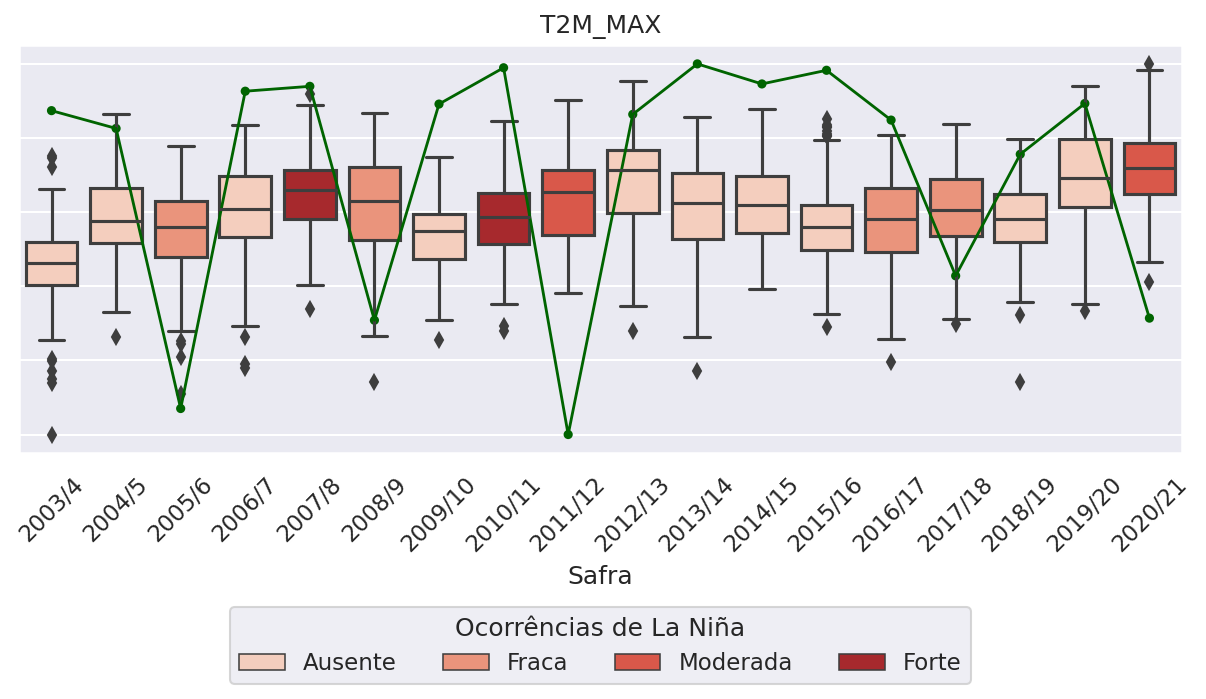

In [ ]:
distr_exo(corb, 'Corbélia', 'T2M_MAX')

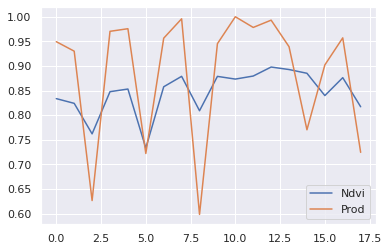

In [ ]:
s1 = rend_city(rend_new, 'Corbélia')
s2 = corb['NDVI'].resample('Y').max().values
s3 = corb['NDVI'].resample('Y').min().values

data = pd.DataFrame({'Ndvi': s2, 'Prod': s1/max(s1)})

data.plot();

In [ ]:
s2 = np.array([1.58,1.55,1.85,1.05,1.74,1.37,1.15,1.63,1.57,1.26,1.7,1.54,1.11,1.19,1.33,1.82,1.55,1.69])

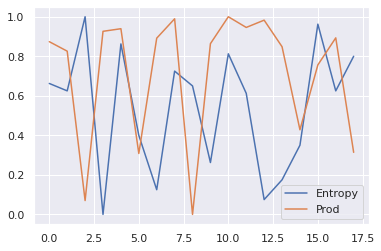

In [ ]:
data = pd.DataFrame({'Entropy': minmax(s2), 'Prod': minmax(s1)})
data.plot();

# Extração de features

## 1 - Considerando algumas features

Referência para features disponíveis:

https://www.rasgoml.com/feature-engineering-tutorials/how-to-create-time-series-features-with-tsfresh

https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [ ]:
# features a serem consideradas
fc_settings = {
    'median': None,
    'maximum': None,
    'minimum': None,
    'quantile': [{'q': 0.25}, {'q': 0.75}],
    'sample_entropy': None
}

In [ ]:
# função para avaliar relação entre série agroclimática e produtividade
def feat_extract(clima_munic, nome, serie):

  # extração das features escolhidas
  features = tsfresh.extract_features(clima_munic[['safra', serie]], 
                                      column_id='safra',
                                      column_sort='safra', 
                                      default_fc_parameters = fc_settings)
  
  # adicionando as ocorrências de La Niña
  features['LA'] = ['N','N','LA1','N','LA3','LA1','N','LA3','LA2','N','N','N','N','LA1','LA1','N','N','LA2']
  features = pd.concat([features, pd.get_dummies(features['LA'])], axis = 1).drop('LA', axis = 1)
  display(features)

  # matriz de features - numpy
  X = features.to_numpy()
  # resposta
  y = rend_city(rend_new, nome)

  # ajuste, gráfico e escore
  lm = LinearRegression()
  lm.fit(X,y)
  y_pred = lm.predict(X)
  
  r2 = np.round(r2_score(y, y_pred),2)

  fig, ax = plt.subplots(figsize=(6,3), dpi = 150)
  sns.regplot(y_pred, y, ax = ax)
  ax.set_xlabel('Rendimento predito')
  ax.set_ylabel('Rendimento real')
  ax.set_title(serie+' - R$^2$ = '+str(r2))
  plt.show()

In [ ]:
feat_extract(corb, 'Corbélia', 'NDVI')

Feature Extraction: 100%|██████████| 18/18 [00:00<00:00, 135.48it/s]


NDVI__median  NDVI__maximum  NDVI__minimum  NDVI__quantile__q_0.25  \
2004       0.46375         0.8336         0.4125                0.431450   
2005       0.47415         0.8240         0.4447                0.453250   
2006       0.50750         0.7620         0.4530                0.483825   
2007       0.51985         0.8477         0.4222                0.444400   
2008       0.46670         0.8531         0.3916                0.417450   
2009       0.52735         0.7332         0.4168                0.430800   
2010       0.52525         0.8577         0.4441                0.459000   
2011       0.45080         0.8789         0.3913                0.420700   
2012       0.51050         0.8090         0.4272                0.456275   
2013       0.53150         0.8788         0.3893                0.414925   
2014       0.47250         0.8733         0.3983                0.421200   
2015       0.49445         0.8795         0.3854                0.415425   
2016       0.59970         0.8978         0.4040                0.424900   
2017       0.52370         0.8927         0.3831                0.415125   
2018       0.46270         0.8851         0.3641                0.386100   
2019       0.62915         0.8398         0.4025                0.484350   
2020       0.44380         0.8762         0.3639                0.380300   
2021       0.40135         0.8171         0.3722                0.386425   

      NDVI__quantile__q_0.75  NDVI__sample_entropy  LA1  LA2  LA3  N  
2004                0.645850              0.162407    0    0    0  1  
2005                0.579100              0.125365    0    0    0  1  
2006                0.681400              0.228097    1    0    0  0  
2007                0.716450              0.187127    0    0    0  1  
2008                0.640275              0.208075    0    0    1  0  
2009                0.626825              0.194592    1    0    0  0  
2010                0.725175              0.155165    0    0    0  1  
2011                0.687850              0.119949    0    0    1  0  
2012                0.718875              0.181479    0    1    0  0  
2013                0.807125              0.140207    0    0    0  1  
2014                0.824125              0.107307    0    0    0  1  
2015                0.829200              0.162994    0    0    0  1  
2016                0.870200              0.138051    0    0    0  1  
2017                0.827875              0.208148    1    0    0  0  
2018                0.739800              0.135131    1    0    0  0  
2019                0.805150              0.176963    0    0    0  1  
2020                0.776500              0.163551    0    0    0  1  
2021                0.545025              0.115656    0    1    0  0

## 2 Considerando todas a features e usando PCA

In [ ]:
# extração
features = tsfresh.extract_features(corb[['safra', 'T2M_MAX']], column_id='safra', column_sort='safra')

Feature Extraction: 100%|██████████| 18/18 [00:03<00:00,  5.39it/s]


In [ ]:
# dropando features que contém NaNs
features = features.dropna(axis = 1)

# removendo features que não variam
features = features.loc[:, (features != features.iloc[0]).any()]
features['LA'] = ['N','N','LA1','N','LA3','LA1','N','LA3','LA2','N','N','N','N','LA1','LA1','N','N','LA2']
features = pd.concat([features, pd.get_dummies(features['LA'])], axis = 1).drop('LA', axis = 1)
print('features obtidas:', features.shape[1])

features obtidas: 576


In [ ]:
# padronizando
X = features.apply(lambda x: minmax(x))
X = X.to_numpy()

In [ ]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 7)
pca.fit(X)
Xpca = pca.transform(X)

In [ ]:
# ajuste, gráfico e escore
lm = LinearRegression()
lm.fit(Xpca,y)

y_pred = lm.predict(Xpca)

print('Escore R2:', r2_score(y, y_pred))
sns.regplot(y_pred, y);

Escore R2: 0.7083027780357146
